### 04_model_evaluation_pretrained:
    Notebook to load the pretrained model trained on VGGFace2 and evalaute it on Labels Faces in the Wild (LFW) face dataset

In [11]:
import sys
sys.path.append("../")

import random
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

from backbone.dataset import Face_Dataset

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [12]:
batch_size = 16

In [13]:
face_data_train = Face_Dataset(root_dir= "../lfw/", file_root = "../files/", 
                               train=True)

train_dataloader = DataLoader(face_data_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

face_data_test = Face_Dataset(root_dir= "../lfw/", 
                              file_root = "../files/", 
                              test=True)

test_dataloader = DataLoader(face_data_test,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)

In [14]:
from backbone.networks.inception_resnet_v1 import InceptionResnetV1

### Load the trained model weights

In [15]:
model = InceptionResnetV1(pretrained='vggface2')
checkpoint = torch.load("../pretrained/20180402-114759-vggface2.pt")
model.load_state_dict(checkpoint)
model = model.cuda()

In [16]:
labels = []
cosine_similarity = []
eucledian_distances = []

for data in test_dataloader:
    
    model.eval()
    with torch.no_grad():
        
        img1 = data[0].cuda()
        img2 = data[1].cuda()
        labels += list(data[2].numpy().flatten().astype(int))
        
        embedding1 = model(img1)
        embedding2 = model(img2)
        
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        cosine_similarity += list(cos(embedding1,embedding2).cpu().numpy())
        
        euclidean_distance = F.pairwise_distance(embedding1, embedding2, keepdim = True)
        eucledian_distances += list(euclidean_distance.cpu().numpy()[0])   

(array([  2.,   9.,  48.,  60.,  77.,  43.,  22.,  36.,  87., 116.]),
 array([-0.27366045, -0.1462944 , -0.01892836,  0.10843769,  0.23580372,
         0.3631698 ,  0.49053583,  0.61790186,  0.7452679 ,  0.87263393,
         1.        ], dtype=float32),
 <a list of 10 Patch objects>)

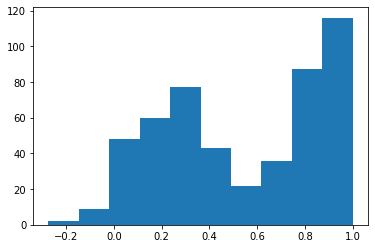

In [17]:
plt.hist(cosine_similarity)

(array([ 94.,   1.,  18.,  58.,  59.,  20.,  52., 110.,  80.,   8.]),
 array([2.2627417e-05, 1.5962370e-01, 3.1922477e-01, 4.7882584e-01,
        6.3842690e-01, 7.9802799e-01, 9.5762902e-01, 1.1172302e+00,
        1.2768312e+00, 1.4364322e+00, 1.5960333e+00], dtype=float32),
 <a list of 10 Patch objects>)

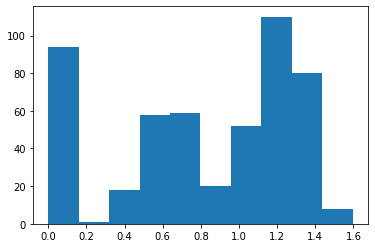

In [18]:
plt.hist(eucledian_distances)

### Determining Threshold

In [19]:
thresholds = list(np.arange(0.3, 1.0, 0.01))

f1_scores = [f1_score(labels, cosine_similarity > t) for t in thresholds]
acc_scores = [accuracy_score(labels, cosine_similarity > t) for t in thresholds] 


Text(0, 0.5, 'F1 Score')

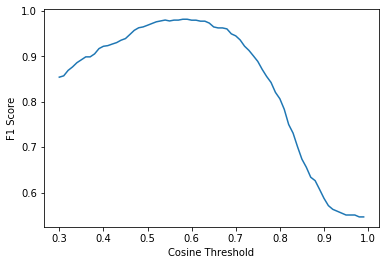

In [24]:
plt.plot(thresholds,f1_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("F1 Score")

Text(0, 0.5, 'Accuracy')

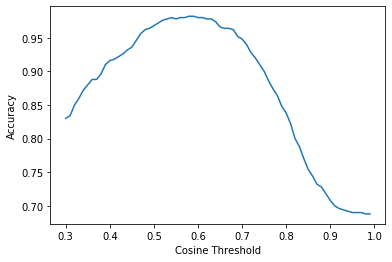

In [25]:
plt.plot(thresholds,acc_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("Accuracy")

In [26]:
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)

In [27]:
print("At threshold : {}, we get a maximum of f1 score : {} ".format(round(thresholds[max_f1_index],4),max_f1))

At threshold : 0.58, we get a maximum of f1 score : 0.9817444219066936 
